# A simple DNN model built in Keras.

In this notebook, we will use the ML datasets we read in with our Keras pipeline earlier and build our Keras DNN to predict the fare amount for NYC taxi cab rides.

### Learning objectives
1. Review how to read in CSV file data using tf.data
2. Specify input, hidden, and output layers in the DNN architecture
3. Review and visualize the final DNN shape
4. Train the model locally and visualize the loss curves
5. Deploy and predict with the model using Cloud AI Platform 

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](../labs/keras_dnn.ipynb) -- try to complete that notebook first before reviewing this solution notebook. 

In [1]:
%%bash
export PROJECT=$(gcloud config list project --format "value(core.project)")
echo "Your current GCP Project Name is: "$PROJECT

Your current GCP Project Name is: cloud-training-demos


In [2]:
import os, json, math
import numpy as np
import shutil
import tensorflow as tf
print("TensorFlow version: ",tf.version.VERSION)

PROJECT = "your-gcp-project-here" # REPLACE WITH YOUR PROJECT NAME
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["REGION"] = REGION
os.environ["BUCKET"] = PROJECT # DEFAULT BUCKET WILL BE PROJECT ID
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # SET TF ERROR LOG VERBOSITY

if PROJECT == "your-gcp-project-here":
  print("Don't forget to update your PROJECT name! Currently:", PROJECT)

TensorFlow version:  2.1.0
Don't forget to update your PROJECT name! Currently: your-gcp-project-here


In [3]:
%%bash
## Create GCS bucket if it doesn't exist already...
exists=$(gsutil ls -d | grep -w gs://${PROJECT}/)

if [ -n "$exists" ]; then
   echo -e "Bucket exists, let's not re-create it. \n\nHere are your buckets:"
   gsutil ls
    
else
   echo "Creating a new GCS bucket."
   gsutil mb -l ${REGION} gs://${PROJECT}
   echo "\nHere are your current buckets:"
   gsutil ls
fi

Bucket exists, let's not re-create it. 

Here are your buckets:
gs://artifacts.cloud-training-demos.appspot.com/
gs://car_damage_lab_images/
gs://car_damage_lab_metadata/
gs://cardinalhealth_proxidata/
gs://cloud-training-demos/
gs://cloud-training-demos-billing-examples/
gs://cloud-training-demos-eu/
gs://cloud-training-demos-lcm/
gs://cloud-training-demos-ml/
gs://cloud-training-demos-movielens/
gs://cloud-training-demos-text/
gs://cloud-training-demos.appspot.com/
gs://dataflow-staging-us-central1-663413318684/
gs://dataprep-staging-21acaac6-da73-45ad-851d-550207730faa/
gs://dataproc-11685141-6479-41ae-a755-e0cde93e4596-us/
gs://df-3047590790675449113-bvodph52g4i6veo2aizbbqaaaa/
gs://df-4515318185045152932-5wwg6c52hai6vfzeaizbbqaaaa/
gs://feat_eng/
gs://feature_engineering_2019_gs/
gs://hostedkfp-default-oo7nezgn59/
gs://hrchatbotdata/
gs://movielens-demo/
gs://recserve_cloud-training-demos/
gs://staging.cloud-training-demos.appspot.com/
gs://tamucc_coastline/
gs://us-central1-datas

## Locating the CSV files

We will start with the CSV files that we wrote out in the [first notebook](../01_explore/taxifare.iypnb) of this sequence. Just so you don't have to run the notebook, we saved a copy in ../../data

In [4]:
!ls -l ../../data/*.csv

-rw-r--r-- 1 jupyter jupyter 123590 Feb 12  2020 ../../data/taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 579055 Feb 12  2020 ../../data/taxi-train.csv
-rw-r--r-- 1 jupyter jupyter 123114 Feb 12  2020 ../../data/taxi-valid.csv


## Use tf.data to read the CSV files

We wrote these cells in the [third notebook](../03_tfdata/solution/input_pipeline.ipynb) of this sequence where we created a data pipeline with Keras.

First let's define our columns of data, which column we're predicting for, and the default values.

In [5]:
CSV_COLUMNS  = ['fare_amount',  'pickup_datetime',
                'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 
                'passenger_count', 'key']
LABEL_COLUMN = 'fare_amount'
DEFAULTS     = [[0.0],['na'],[0.0],[0.0],[0.0],[0.0],[0.0],['na']]

Next, let's define our features we want to use and our label(s) and then load in the dataset for training.

In [6]:
def features_and_labels(row_data):
    for unwanted_col in ['pickup_datetime', 'key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             )
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
  return dataset

## Build a DNN with Keras

Now let's build the Deep Neural Network (DNN) model in Keras and specify the input and hidden layers. We will print out the DNN architecture and then visualize it later on.

In [7]:
## Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

def build_dnn_model():
    INPUT_COLS = ['pickup_longitude', 'pickup_latitude', 
                  'dropoff_longitude', 'dropoff_latitude', 
                  'passenger_count']

    # input layer
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in INPUT_COLS
    }
    feature_columns = {
        colname : tf.feature_column.numeric_column(colname)
           for colname in INPUT_COLS
    }
    
    # the constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires that you specify: LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation='linear', name='fare')(h2)
    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dropoff_latitude (InputLayer)   [(None,)]            0                                            
__________________________________________________________________________________________________
dropoff_longitude (InputLayer)  [(None,)]            0                                            
__________________________________________________________________________________________________
passenger_count (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
pickup_latitude (InputLayer)    [(None,)]            0                                            
________________________________________________________

### Visualize the DNN

We can visualize the DNN using the Keras [plot_model](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/utils/plot_model) utility.

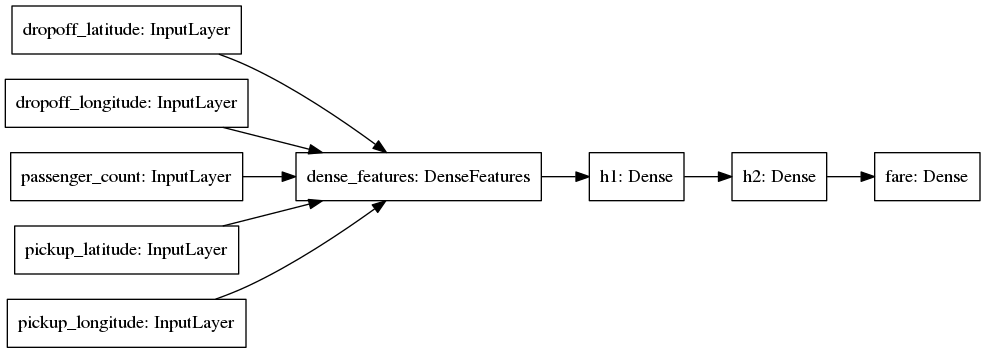

In [8]:
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

## Train the model

To train the model, simply call [model.fit()](https://keras.io/models/model/#fit).

Note that we should really use many more NUM_TRAIN_EXAMPLES (i.e. a larger dataset). We shouldn't make assumptions about the quality of the model based on training/evaluating it on a small sample of the full data.

In [9]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 5  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('../../data/taxi-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('../../data/taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

Train for 312 steps, validate for 10 steps
Epoch 1/5
312/312 [==============================] - 2s 6ms/step - loss: 140.5708 - rmse: 10.4596 - mse: 140.5707 - val_loss: 112.0405 - val_rmse: 10.5725 - val_mse: 112.0405
Epoch 2/5
312/312 [==============================] - 1s 3ms/step - loss: 95.0024 - rmse: 9.1054 - mse: 95.0024 - val_loss: 109.7135 - val_rmse: 10.4515 - val_mse: 109.7135
Epoch 3/5
312/312 [==============================] - 1s 3ms/step - loss: 98.6180 - rmse: 9.3263 - mse: 98.6181 - val_loss: 109.9556 - val_rmse: 10.4498 - val_mse: 109.9556
Epoch 4/5
312/312 [==============================] - 1s 3ms/step - loss: 98.3035 - rmse: 9.2382 - mse: 98.3035 - val_loss: 112.2877 - val_rmse: 10.5789 - val_mse: 112.2877
Epoch 5/5
312/312 [==============================] - 1s 2ms/step - loss: 102.7374 - rmse: 9.4375 - mse: 102.7373 - val_loss: 109.4231 - val_rmse: 10.4403 - val_mse: 109.4231


### Visualize the model loss curve

Next, we will use matplotlib to draw the model's loss curves for training and validation.

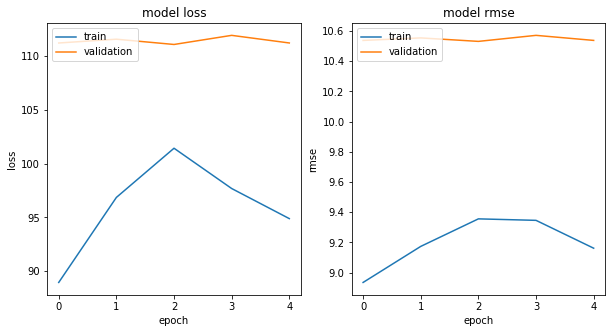

In [103]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Predict with the model locally

To predict with Keras, you simply call [model.predict()](https://keras.io/models/model/#predict) and pass in the cab ride you want to predict the fare amount for.

In [104]:
model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),    
}, steps=1)

array([[11.430003]], dtype=float32)

Of course, this is not realistic, because we can't expect client code to have a model object in memory. We'll have to export our model to a file, and expect client code to instantiate the model from that exported file.

## Export the model for serving

Let's export the model to a TensorFlow SavedModel format. Once we have a model in this format, we have lots of ways to "serve" the model, from a web application, from JavaScript, from mobile applications, etc.

In [105]:
import shutil, os, datetime
OUTPUT_DIR = './export/savedmodel'
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR, datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
tf.saved_model.save(model, EXPORT_PATH) # with default serving function

INFO:tensorflow:Assets written to: ./export/savedmodel/20190922210532/assets


In [106]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir {EXPORT_PATH}
!find {EXPORT_PATH}
os.environ['EXPORT_PATH'] = EXPORT_PATH

The given SavedModel SignatureDef contains the following input(s):
  inputs['dropoff_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dropoff_latitude:0
  inputs['dropoff_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dropoff_longitude:0
  inputs['passenger_count'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_passenger_count:0
  inputs['pickup_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_pickup_latitude:0
  inputs['pickup_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_pickup_longitude:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['fare'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict
./export/savedmodel/20190922210532
./export/savedmodel/201909222105

## Deploy the model to AI Platform

Next, we will use the `gcloud ai-platform` command to create a new version for our __taxifare__ model and give it the version name of __dnn__. 

Deploying the model will take 5 - 10 minutes. 

In [ ]:
%%bash
PROJECT=${PROJECT}
BUCKET=${BUCKET}
REGION=${REGION}
MODEL_NAME=taxifare
VERSION_NAME=dnn

if [[ $(gcloud ai-platform models list --format='value(name)' | grep $MODEL_NAME) ]]; then
    echo "The model named $MODEL_NAME already exists."
else
    # create model
    echo "Creating $MODEL_NAME model now."
    gcloud ai-platform models create --regions=$REGION $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format='value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting already the existing model $MODEL_NAME:$VERSION_NAME ... "
    gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 2
fi

# create model
echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud ai-platform versions create --model=$MODEL_NAME $VERSION_NAME --async \
       --framework=tensorflow --python-version=3.5 --runtime-version=1.15 \
       --origin=$EXPORT_PATH --staging-bucket=gs://$BUCKET

Monitor the model creation at [GCP Console > AI Platform](https://console.cloud.google.com/mlengine/models/taxifare/) and once the model version `dnn` is created, proceed to the next cell.

### Predict with model using `gcloud ai-platform predict`

To predict with the model, we first need to create some data that the model hasn't seen before. Let's predict for a new taxi cab ride for you and two friends going from [from Kips Bay and heading to Midtown Manhattan](https://www.google.com/maps/dir/40.742104,-73.982683/'40.755174,-73.983766'/@40.7487493,-73.9892016,16z/data=!3m1!4b1!4m6!4m5!1m0!1m3!2m2!1d-73.983766!2d40.755174) for a total distance of 1.3 miles. How much would that cost?

In [114]:
%%writefile input.json
{"pickup_longitude": -73.982683, "pickup_latitude": 40.742104,"dropoff_longitude": -73.983766,"dropoff_latitude": 40.755174,"passenger_count": 3.0}  

Writing input.json


In [115]:
!gcloud ai-platform predict --model taxifare --json-instances input.json --version dnn

FARE
[11.430005073547363]


To take a quick anonymous survey, run:
  $ gcloud alpha survey



In the [next notebook](../05_feateng), we will improve this model through feature engineering.

Copyright 2019 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.